<a href="https://colab.research.google.com/github/merazAfridi/Blood-Cell-Segmentation/blob/main/4_Ternausnet_Blood_cell_seg_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras


In [ ]:
import tensorflow as tf
import google.protobuf

print("TensorFlow version:", tf.__version__)
print("Protobuf version:", google.protobuf.__version__)


TensorFlow version: 1.15.0
Protobuf version: 3.19.0


In [ ]:
data_path = r'C:\Users\User\Final data'

In [ ]:
image_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
mask_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'

(1328, 128, 128, 3)
uint8


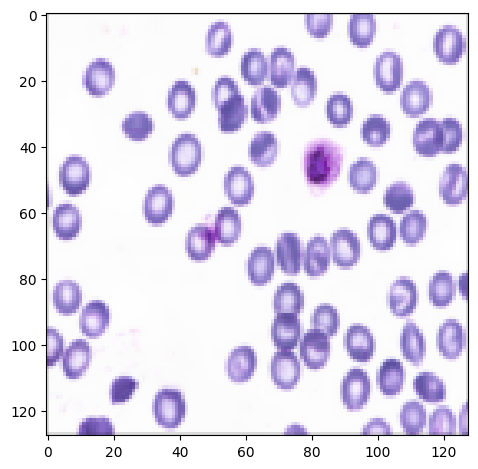

In [ ]:
#X train pure images from dataset
row = 128
columns = 128

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
training_images = os.listdir(train_data_path)
training_images.sort()


X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_images:
    path = os.path.join(image_data_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    X[index] = image
    index += 1

print(X.shape)

print(X.dtype)
imshow(X[0])

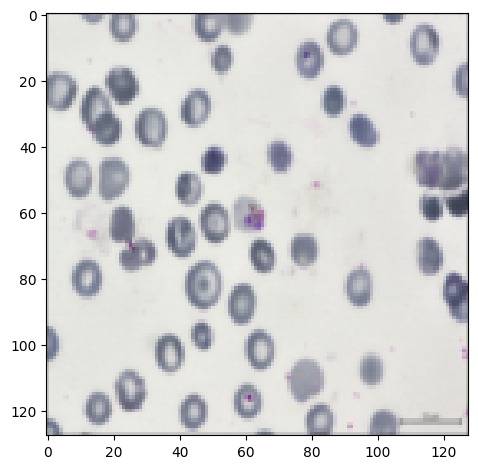

In [ ]:
imshow(X[10])

(1328, 128, 128, 3)
uint8


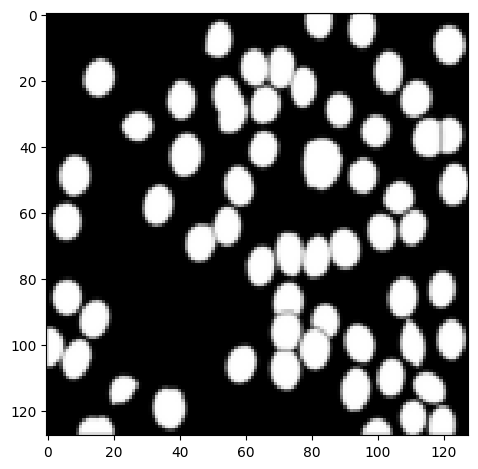

In [ ]:
## y train pure masks from dataset

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'
training_masks = os.listdir(train_data_path)
training_masks.sort()

y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_masks:
    path = os.path.join(mask_data_path, x)
#     print(path)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y[index] = image
    index += 1

print(y.shape)
type(y)
print(y.dtype)
imshow(y[0])

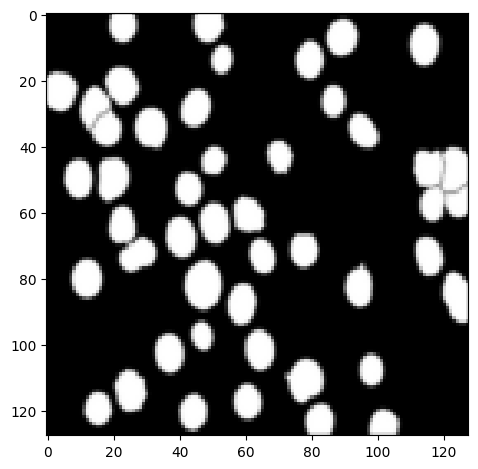

In [ ]:
imshow(y[10])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)


(1062, 128, 128, 3)
(1062, 128, 128, 3)

(266, 128, 128, 3)
(266, 128, 128, 3)


In [ ]:
def dice_coef(a, b):

    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [ ]:
#Libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose
# from keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf


In [ ]:
# Import necessary libraries from TensorFlow's Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, add, multiply
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16


def decoder_block_ternausV2(inputs, mid_channels, out_channels):
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  # (batch, height, width, channels)
    )
    x = UpSampling2D(size=(2, 2))(inputs)
    x = Conv2D(mid_channels, 3, **conv_kwargs)(x)
    x = Conv2D(out_channels, 3, **conv_kwargs)(x)
    return x


def ternausNet16(input_size=(128, 128, 3), output_channels=1):
    # input
    inputs = Input(input_size)

    # Load pretrained VGG16, adjust input size for 128x128
    encoder = VGG16(include_top=False, weights='imagenet', input_tensor=inputs, input_shape=input_size)

    # Encoder layers
    e1 = encoder.get_layer('block1_conv1').output
    e1 = encoder.get_layer('block1_conv2')(e1)  # (None, 128, 128, 64)

    e2 = MaxPooling2D(pool_size=(2, 2))(e1)
    e2 = encoder.get_layer('block2_conv1')(e2)
    e2 = encoder.get_layer('block2_conv2')(e2)  # (None, 64, 64, 128)

    e3 = MaxPooling2D(pool_size=(2, 2))(e2)
    e3 = encoder.get_layer('block3_conv1')(e3)
    e3 = encoder.get_layer('block3_conv2')(e3)
    e3 = encoder.get_layer('block3_conv3')(e3)  # (None, 32, 32, 256)

    e4 = MaxPooling2D(pool_size=(2, 2))(e3)
    e4 = encoder.get_layer('block4_conv1')(e4)
    e4 = encoder.get_layer('block4_conv2')(e4)
    e4 = encoder.get_layer('block4_conv3')(e4)  # (None, 16, 16, 512)

    e5 = MaxPooling2D(pool_size=(2, 2))(e4)
    e5 = encoder.get_layer('block5_conv1')(e5)
    e5 = encoder.get_layer('block5_conv2')(e5)
    e5 = encoder.get_layer('block5_conv3')(e5)  # (None, 8, 8, 512)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(e5)  # (None, 4, 4, 512)
    center = decoder_block_ternausV2(center, 512, 256)  # (None, 8, 8, 256)

    # Decoder blocks
    d5 = concatenate([e5, center], axis=3)
    d5 = decoder_block_ternausV2(d5, 512, 256)  # (None, 16, 16, 256)

    d4 = concatenate([e4, d5], axis=3)
    d4 = decoder_block_ternausV2(d4, 512, 128)  # (None, 32, 32, 128)

    d3 = concatenate([e3, d4], axis=3)
    d3 = decoder_block_ternausV2(d3, 256, 64)  # (None, 64, 64, 64)

    d2 = concatenate([e2, d3], axis=3)
    d2 = decoder_block_ternausV2(d2, 128, 64)  # (None, 128, 128, 64)

    # Final output layer
    d1 = concatenate([e1, d2], axis=3)
    d1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(d1)
    d1 = ReLU()(d1)  # (None, 128, 128, 32)

    # Output
    op = Conv2D(output_channels, 1)(d1)
    op = Activation('sigmoid')(op)

    # Model creation
    model = Model(inputs=[inputs], outputs=[op])

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.5,
        staircase=True)

    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16

def decoder_block_ternausV2(inputs, mid_channels, out_channels):
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'
    )

    x = UpSampling2D(size=(2, 2))(inputs)
    x = Conv2D(mid_channels, 3, **conv_kwargs)(x)
    x = Conv2D(out_channels, 3, **conv_kwargs)(x)
    return x

def ternausNet16(input_size=(128, 128, 3), output_channels=3):
    # input
    inputs = Input(input_size)

    # Convert to 3 channels if input is grayscale
    if input_size[-1] < 3:
        x = Conv2D(3, 1)(inputs)                         # add channels
        input_shape = (input_size[0], input_size[0], 3)  # update input size
    else:
        x = inputs
        input_shape = input_size

    # Load pretrained VGG16, conv layers include relu activation
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    # Encoder
    e1 = encoder.get_layer(name='block1_conv1')(x)
    e1 = encoder.get_layer(name='block1_conv2')(e1)
    e2 = MaxPooling2D(pool_size=(2, 2))(e1)
    e2 = encoder.get_layer(name='block2_conv1')(e2)
    e2 = encoder.get_layer(name='block2_conv2')(e2)
    e3 = MaxPooling2D(pool_size=(2, 2))(e2)
    e3 = encoder.get_layer(name='block3_conv1')(e3)
    e3 = encoder.get_layer(name='block3_conv2')(e3)
    e3 = encoder.get_layer(name='block3_conv3')(e3)
    e4 = MaxPooling2D(pool_size=(2, 2))(e3)
    e4 = encoder.get_layer(name='block4_conv1')(e4)
    e4 = encoder.get_layer(name='block4_conv2')(e4)
    e4 = encoder.get_layer(name='block4_conv3')(e4)
    e5 = MaxPooling2D(pool_size=(2, 2))(e4)
    e5 = encoder.get_layer(name='block5_conv1')(e5)
    e5 = encoder.get_layer(name='block5_conv2')(e5)
    e5 = encoder.get_layer(name='block5_conv3')(e5)

    # Bottleneck
    center = MaxPooling2D(pool_size=(2, 2))(e5)
    center = decoder_block_ternausV2(center, 512, 256)

    # Decoder
    d5 = concatenate([e5, center], axis=3)
    d5 = decoder_block_ternausV2(d5, 512, 256)
    d4 = concatenate([e4, d5], axis=3)
    d4 = decoder_block_ternausV2(d4, 512, 128)
    d3 = concatenate([e3, d4], axis=3)
    d3 = decoder_block_ternausV2(d3, 256, 64)
    d2 = concatenate([e2, d3], axis=3)
    d2 = decoder_block_ternausV2(d2, 128, 64)
    d1 = concatenate([e1, d2], axis=3)
    d1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(d1)
    d1 = ReLU()(d1)

    # Output layer with 3 channels
    op = Conv2D(output_channels, 1)(d1)
    op = Activation('sigmoid')(op)  # Using 'sigmoid' since it's binary segmentation

    # Model definition
    model = Model(inputs=[inputs], outputs=[op])

    # Compile with an appropriate optimizer and loss
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])

    return model


In [ ]:
model = ternausNet16()

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 64, 64, 64)   0           block1_conv2[1][0]               
____________________________________________________________________________________________

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1062, 128, 128, 3)
(1062, 128, 128, 3)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(266, 128, 128, 3)
(266, 128, 128, 3)


In [ ]:
filepath = r"C:\Users\User\Blood Cell Seg ipybn\Ternausnet/cp.ckpt"

# Import necessary callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper,

history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=5, callbacks=callbacks_list)

Train on 955 samples, validate on 107 samples
Epoch 1/5
952/955 [============================>.] - ETA: 13s - loss: nan - dice_coef: nan - jaccard_index: nan
Epoch 00001: val_loss did not improve from inf
955/955 [==============================] - 4592s 5s/sample - loss: nan - dice_coef: nan - jaccard_index: nan - val_loss: nan - val_dice_coef: nan - val_jaccard_index: nan
Epoch 2/5
952/955 [============================>.] - ETA: 12s - loss: nan - dice_coef: nan - jaccard_index: nan
Epoch 00002: val_loss did not improve from inf
955/955 [==============================] - 3976s 4s/sample - loss: nan - dice_coef: nan - jaccard_index: nan - val_loss: nan - val_dice_coef: nan - val_jaccard_index: nan
Epoch 3/5
952/955 [============================>.] - ETA: 12s - loss: nan - dice_coef: nan - jaccard_index: nan
Epoch 00003: val_loss did not improve from inf
955/955 [==============================] - 4142s 4s/sample - loss: nan - dice_coef: nan - jaccard_index: nan - val_loss: nan - val_dice

In [ ]:
#from keras.models import load_model
#model = load_model('./assets')
#model.load_weights('')

test_preds = model.predict(X_test)
print(test_preds.shape)
print(type(test_preds))

(266, 128, 128, 3)
<class 'numpy.ndarray'>


<class 'numpy.ndarray'>
(266, 128, 128, 3)
float32


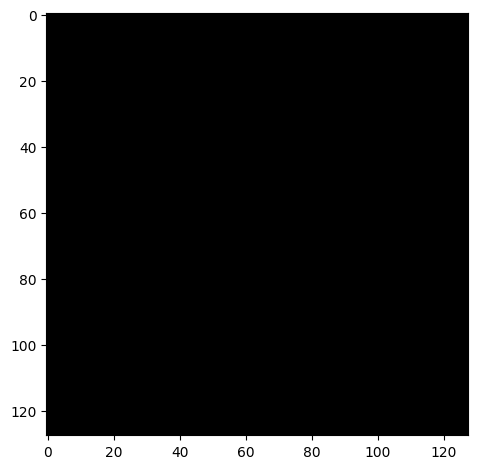

In [ ]:
print(type(test_preds))
print(test_preds.shape)
print(test_preds.dtype)
#print(test_preds[0])
imshow(test_preds[0])

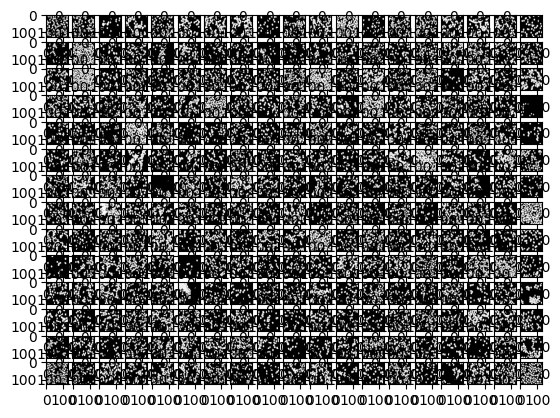

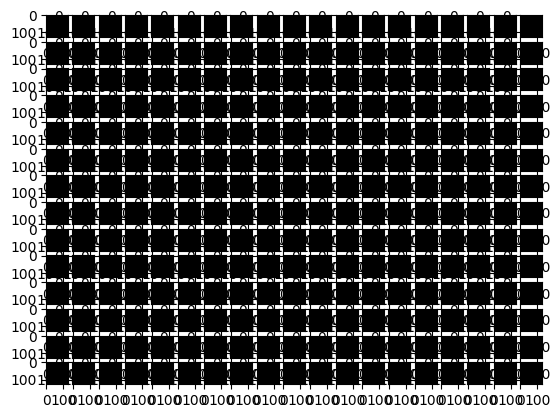

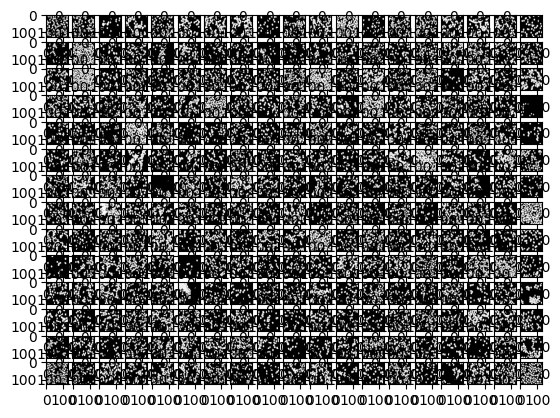

In [ ]:
from skimage.io import imshow_collection
imshow_collection(test_preds)
imshow_collection(y_test)

In [ ]:
#Evaluating Individual Dice-Co efficient
#Metrics for individual evaluation

In [ ]:
def dice_coef2(a, b):

    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

uint8
float32
Dice Co-efficient:  Tensor("truediv_1089:0", shape=(), dtype=float32)
Jaccard-index:  Tensor("truediv_1091:0", shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


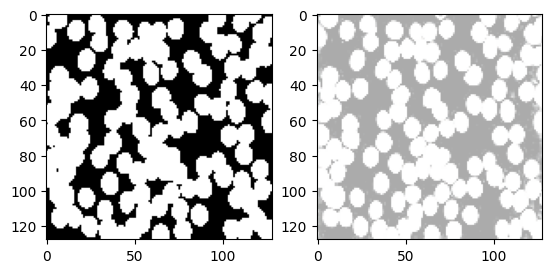

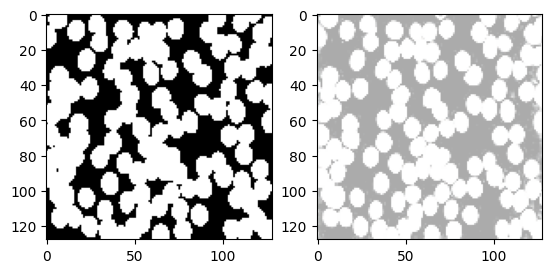

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.io import imshow_collection

# correct data type for y_test and avg_output
print(y_test[0].dtype)  # Expected to be uint8
print(avg_output[0].dtype)  # Expected to be float32

# Convert both to the same dtype (e.g., float32)
i = tf.cast(y_test[0], dtype=tf.float32)
j = tf.cast(avg_output[0], dtype=tf.float32)

# Calculate Dice Coefficient
result = dice_coef2(i, j)
print('Dice Co-efficient: ', result)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
print('Jaccard-index: ', result2)

# same shape for both images
if i.shape != j.shape:
    j = tf.image.resize(j, i.shape[:2])  # Resize j to match i

# Convert Tensor to NumPy array
with tf.compat.v1.Session() as sess:
    i_np = i.eval(session=sess)
    j_np = j.eval(session=sess)

# Prepare for displaying
x = np.zeros((2, i_np.shape[0], i_np.shape[1], 3))  # Assuming 3 channels (RGB)
x[0] = i_np
x[1] = j_np

# Display the collection of images
imshow_collection(x)


uint8
float32
Dice Co-efficient:  Tensor("truediv_1093:0", shape=(), dtype=float32)
Jaccard-index:  Tensor("truediv_1095:0", shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


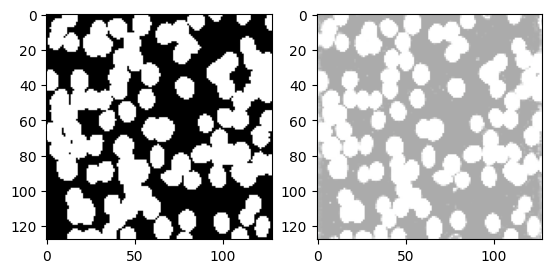

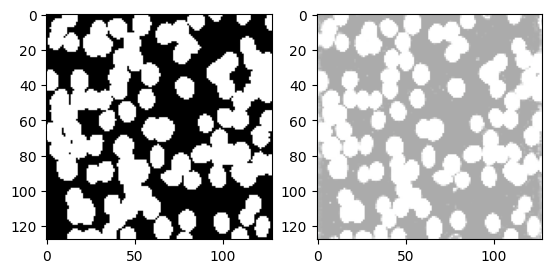

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.io import imshow_collection

# correct data type for y_test and avg_output
print(y_test[1].dtype)  # Expected to be uint8
print(avg_output[1].dtype)  # Expected to be float32

# Convert both to the same dtype (e.g., float32)
i = tf.cast(y_test[1], dtype=tf.float32)
j = tf.cast(avg_output[1], dtype=tf.float32)

# Calculate Dice Coefficient
result = dice_coef2(i, j)
print('Dice Co-efficient: ', result)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
print('Jaccard-index: ', result2)

# same shape for both images
if i.shape != j.shape:
    j = tf.image.resize(j, i.shape[:2])  # Resize j to match i

# Convert Tensor to NumPy array
with tf.compat.v1.Session() as sess:
    i_np = i.eval(session=sess)
    j_np = j.eval(session=sess)

# Prepare for displaying
x = np.zeros((2, i_np.shape[0], i_np.shape[1], 3))  # Assuming 3 channels (RGB)
x[0] = i_np
x[1] = j_np

# Display the collection of images
imshow_collection(x)


In [ ]:
# Avoid calculating metrics for all-zero masks
mask_valid = tf.reduce_sum(y_test, axis=[1, 2, 3]) > 0
y_test = tf.boolean_mask(y_test, mask_valid)
avg_output = tf.boolean_mask(avg_output, mask_valid)


In [ ]:
#Average Test Dice Co-efficient, Jaccard index

import tensorflow as tf
import numpy as np

# Initialize average values for Dice and Jaccard
avg_dice = 0
avg_jaccard = 0

# Loop through test data and predictions
for x in range(len(avg_output)):
    i = tf.cast(y_test[x], dtype=tf.float32)  # Cast y_test[x] to float32 to match avg_output
    j = avg_output[x]

    # Compute dice coefficient and jaccard index
    dice = dice_coef2(i, j)
    jaccard = jaccard_index2(i, j)

    # Add their values to the running totals
    avg_dice += tf.keras.backend.get_value(dice)
    avg_jaccard += tf.keras.backend.get_value(jaccard)

# Calculate averages
avg_dice /= len(avg_output)
avg_jaccard /= len(avg_output)

# Output the results
print('Average Test Dice Co-efficient: ', avg_dice)
print('Average Test Jaccard Index: ', avg_jaccard)

In [ ]:
history

In [ ]:
#Highest and lowest

print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))

Lowest training loss:  nan
Lowest validation loss:  nan
Highest training dice coefficient:  nan
Highest validation dice coefficient:  nan
Highest training jaccrad index:  nan
Highest validation jaccard index:  nan
